# PEFT 库 QLoRA 实战 - ChatGLM3-6B

通常，模型被量化后不会进一步训练用于下游任务，因为由于权重和激活的较低精度，训练可能不稳定。

但是由于PEFT方法只添加额外的可训练参数，这使得我们可以使用PEFT适配器（Adapter）来训练一个量化模型！将量化与PEFT结合起来可以成为在单个GPU上训练大模型的微调策略。

例如，QLoRA 是一种将模型量化为4位然后使用LoRA进行训练的方法，使得在单个16GB GPU（本教程以 NVIDIA T4为例）上微调一个具有65B参数的大模型成为可能。

THUDM Hugging Face 主页：https://huggingface.co/THUDM

# 教程说明

本教程使用 QLoRA 论文中介绍的量化技术：NF4 数据类型、双量化 和 混合精度计算，在 ChatGLM3-6b 模型上实现了 QLoRA 微调。并展示了完整的 QLoRA 微调流程，具体如下：

数据准备
- 下载数据集
- 设计 Tokenizer 函数处理样本（map、shuffle、flatten）
- 自定义批量数据处理类 DataCollatorForChatGLM

训练模型
- 加载 ChatGLM3-6B 量化模型
- PEFT 量化模型预处理（prepare_model_for_kbit_training）
- QLoRA 适配器配置（TRANSFORMERS_MODELS_TO_LORA_TARGET_MODULES_MAPPING）
- 微调训练超参数配置（TrainingArguments）
- 开启训练（trainer.train)
- 保存QLoRA模型（trainer.model.save_pretrained)

模型推理
- 加载 ChatGLM3-6B 基础模型
- 加载 ChatGLM3-6B QLoRA 模型（PEFT Adapter）
- 微调前后对比

In [1]:
# 定义全局变量和参数
model_name_or_path = 'THUDM/chatglm3-6b'  # 模型ID或本地路径
train_data_path = 'HasturOfficial/adgen'    # 训练数据路径
eval_data_path = None                     # 验证数据路径，如果没有则设置为None
seed = 8                                 # 随机种子
max_input_length = 512                    # 输入的最大长度
max_output_length = 1536                  # 输出的最大长度
lora_rank = 4                             # LoRA秩
lora_alpha = 32                           # LoRA alpha值
lora_dropout = 0.05                       # LoRA Dropout率
resume_from_checkpoint = None             # 如果从checkpoint恢复训练，指定路径
prompt_text = ''                          # 所有数据前的指令文本
compute_dtype = 'fp32'                    # 计算数据类型（fp32, fp16, bf16）

## 数据准备

### 下载数据集

从 Hugging Face 加载 adgen 数据集，并tokenize，shuffle

In [2]:
from datasets import load_dataset

dataset = load_dataset(train_data_path)

In [3]:
dataset

DatasetDict({
    train: Dataset({
        features: ['content', 'summary'],
        num_rows: 114599
    })
    validation: Dataset({
        features: ['content', 'summary'],
        num_rows: 1070
    })
})

In [4]:
from datasets import ClassLabel, Sequence
import random
import pandas as pd
from IPython.display import display, HTML

def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)
    
    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
        elif isinstance(typ, Sequence) and isinstance(typ.feature, ClassLabel):
            df[column] = df[column].transform(lambda x: [typ.feature.names[i] for i in x])
    display(HTML(df.to_html()))

In [5]:
show_random_elements(dataset["train"], num_examples=3)

,content,summary
0,类型#上衣*颜色#白色*颜色#粉色*风格#清新*图案#蝴蝶结*图案#创意*衣样式#开衫*衣领型#圆领*衣款式#拼接*衣款式#收腰,这款女童连衣裙选用甜蜜糖果粉色调，满溢清新气息。简洁船型圆领贴合脖颈，尽显精致五官轮廓。上身细腻开衫端庄不失时尚范，下身挺括百褶裙公主气质满满，二者创意拼接，完美诠释着品牌设计感。立体蝴蝶结自然点缀着收腰，轻松俘获少女心。裙摆<UNK>装饰别致不失俏皮，出街吸睛度更高。后领采用<UNK>白色<UNK>装饰，既美观又方便穿脱。
1,类型#上衣*材质#蕾丝*图案#蕾丝*衣样式#衬衫,这款很有职业风格的衬衫采用轻薄的材质打造，穿起来不仅增加了清爽自由感，还尽显十足的亲肤性。蕾丝元素的修饰和点缀衬托出十足的柔美气息，加上花边的修饰，衬托出不错的法式浪漫气息，结合素雅的色调设计，穿起来更加明亮。
2,类型#裤*版型#显瘦*颜色#黑色*风格#简约*图案#线条*裤腰型#松紧腰*裤口#小脚,这条黑色的小脚裤，采用了独特的罗马汗布，有很好的吸湿和透气性，可以避免不必要的尴尬，还非常的舒适有弹力。超级修身的版型，时尚又大方，展现你的好身材。松紧腰围的设计，可以无意间拉伸你的腿部线条，让你看起来显瘦又显高。黑色将简约风进行到底，更显气质也落落大方。


## 使用 ChatGLM3-6b Tokenizer 处理数据

关于 ignore_label_id 的设置：

在许多自然语言处理和机器学习框架中，ignore_label_id 被设置为 -100 是一种常见的约定。这个特殊的值用于标记在计算损失函数时应该被忽略的目标标签。让我们详细了解一下这个选择的原因：

1.损失函数忽略特定值：训练语言模型时，损失函数（例如交叉熵损失）通常只计算对于模型预测重要或关键的标签的损失。在某些情况下，你可能不希望某些标签对损失计算产生影响。例如，在序列到序列的模型中，输入部分的标签通常被设置为一个忽略值，因为只有输出部分的标签对于训练是重要的。

2.为何选择-100：这个具体的值是基于实现细节选择的。在 PyTorch 的交叉熵损失函数中，可以指定一个 ignore_index 参数。当损失函数看到这个索引值时，它就会忽略对应的输出标签。使用 -100 作为默认值是因为它是一个不太可能出现在标签中的数字（特别是在处理分类问题时，标签通常是从0开始的正整数）。

3.标准化和通用性：由于这种做法在多个库和框架中被采纳，-100 作为忽略标签的默认值已经变得相对标准化，这有助于维护代码的通用性和可读性。

总的来说，将 ignore_label_id 设置为 -100 是一种在计算损失时排除特定标签影响的便捷方式。这在处理特定类型的自然语言处理任务时非常有用，尤其是在涉及序列生成或修改的任务中。

### 关于 ChatGLM3 的填充处理说明

- input_id（query）里的填充补全了输入长度，目的是不改变原始文本的含义。
- label（answer）里的填充会用来跟模型基于 query 生成的结果计算 Loss，为了不影响损失值计算，也需要设置。咱们计算损失时，是针对 answer 部分的 Embedding Vector，因此 label 这样填充，前面的序列就自动忽略掉了，只比较生成内容的 loss。因此，需要将answer前面的部分做忽略填充。

In [6]:
from transformers import AutoTokenizer

# revision='b098244' 版本对应的 ChatGLM3-6B 设置 use_reentrant=False
# 最新版本 use_reentrant 被设置为 True，会增加不必要的显存开销
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path,
                                          trust_remote_code=True,
                                          revision='b098244')

In [7]:
# tokenize_func 函数
def tokenize_func(example, tokenizer, ignore_label_id=-100):
    """
    对单个数据样本进行tokenize处理。

    参数:
    example (dict): 包含'content'和'summary'键的字典，代表训练数据的一个样本。
    tokenizer (transformers.PreTrainedTokenizer): 用于tokenize文本的tokenizer。
    ignore_label_id (int, optional): 在label中用于填充的忽略ID，默认为-100。

    返回:
    dict: 包含'tokenized_input_ids'和'labels'的字典，用于模型训练。
    """

    # 构建问题文本
    question = prompt_text + example['content']
    if example.get('input', None) and example['input'].strip():
        question += f'\n{example["input"]}'

    # 构建答案文本
    answer = example['summary']

    # 对问题和答案文本进行tokenize处理
    q_ids = tokenizer.encode(text=question, add_special_tokens=False)
    a_ids = tokenizer.encode(text=answer, add_special_tokens=False)

    # 如果tokenize后的长度超过最大长度限制，则进行截断
    if len(q_ids) > max_input_length - 2:  # 保留空间给gmask和bos标记
        q_ids = q_ids[:max_input_length - 2]
    if len(a_ids) > max_output_length - 1:  # 保留空间给eos标记
        a_ids = a_ids[:max_output_length - 1]

    # 构建模型的输入格式
    input_ids = tokenizer.build_inputs_with_special_tokens(q_ids, a_ids)
    question_length = len(q_ids) + 2  # 加上gmask和bos标记

    # 构建标签，对于问题部分的输入使用ignore_label_id进行填充
    labels = [ignore_label_id] * question_length + input_ids[question_length:]

    return {'input_ids': input_ids, 'labels': labels}

In [8]:
column_names = dataset['train'].column_names
tokenized_dataset = dataset['train'].map(
    lambda example: tokenize_func(example, tokenizer),
    batched=False, 
    remove_columns=column_names
)

In [9]:
show_random_elements(tokenized_dataset, num_examples=1)

,input_ids,labels
0,"[64790, 64792, 30910, 33467, 31010, 49534, 30998, 55090, 54888, 31010, 30919, 30998, 38317, 31010, 55534, 57375, 30998, 33692, 31010, 34298, 30998, 32799, 31010, 40512, 30998, 55500, 46025, 31010, 55534, 57375, 57439, 30998, 55500, 54847, 54888, 31010, 54748, 54847, 30998, 55500, 40877, 31010, 58456, 56837, 35182, 54986, 54803, 31952, 55534, 57375, 57439, 31123, 42733, 34298, 31735, 31123, 36350, 41606, 54530, 39006, 54592, 31155, 40512, 54530, 40877, 31123, 30919, 54530, 55090, 54888, 31123, 31685, 38327, 38088, 35752, 34219, 31123, 31701, 42907, 35669, 56115, 56150, 55656, 39602, 56409, 31155, 54748, 54847, 40877, 32985, 45889, 58456, 56837, 40877, 31123, 31628, 31942, 43518, 57777, 56682, ...]","[-100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, 35182, 54986, 54803, 31952, 55534, 57375, 57439, 31123, 42733, 34298, 31735, 31123, 36350, 41606, 54530, 39006, 54592, 31155, 40512, 54530, 40877, 31123, 30919, 54530, 55090, 54888, 31123, 31685, 38327, 38088, 35752, 34219, 31123, 31701, 42907, 35669, 56115, 56150, 55656, 39602, 56409, 31155, 54748, 54847, 40877, 32985, 45889, 58456, 56837, 40877, 31123, 31628, 31942, 43518, 57777, 56682, ...]"


### 数据集处理：shuffle & flatten

洗牌(shuffle)会将数据集的索引列表打乱，以创建一个索引映射。

然而，一旦您的数据集具有索引映射，速度可能会变慢10倍。这是因为需要额外的步骤来使用索引映射获取要读取的行索引，并且最重要的是，您不再连续地读取数据块。

要恢复速度，需要再次使用 Dataset.flatten_indices()将整个数据集重新写入磁盘上，从而删除索引映射。

ref: https://huggingface.co/docs/datasets/v2.15.0/en/package_reference/main_classes#datasets.Dataset.flatten_indices

In [10]:
tokenized_dataset = tokenized_dataset.shuffle(seed=seed)

In [11]:
tokenized_dataset = tokenized_dataset.flatten_indices()

### 定义 DataCollatorForChatGLM 类 批量处理数据

In [12]:
import torch
from typing import List, Dict, Optional

# DataCollatorForChatGLM 类
class DataCollatorForChatGLM:
    """
    用于处理批量数据的DataCollator，尤其是在使用 ChatGLM 模型时。

    该类负责将多个数据样本（tokenized input）合并为一个批量，并在必要时进行填充(padding)。

    属性:
    pad_token_id (int): 用于填充(padding)的token ID。
    max_length (int): 单个批量数据的最大长度限制。
    ignore_label_id (int): 在标签中用于填充的ID。
    """

    def __init__(self, pad_token_id: int, max_length: int = 2048, ignore_label_id: int = -100):
        """
        初始化DataCollator。

        参数:
        pad_token_id (int): 用于填充(padding)的token ID。
        max_length (int): 单个批量数据的最大长度限制。
        ignore_label_id (int): 在标签中用于填充的ID，默认为-100。
        """
        self.pad_token_id = pad_token_id
        self.ignore_label_id = ignore_label_id
        self.max_length = max_length

    def __call__(self, batch_data: List[Dict[str, List]]) -> Dict[str, torch.Tensor]:
        """
        处理批量数据。

        参数:
        batch_data (List[Dict[str, List]]): 包含多个样本的字典列表。

        返回:
        Dict[str, torch.Tensor]: 包含处理后的批量数据的字典。
        """
        # 计算批量中每个样本的长度
        len_list = [len(d['input_ids']) for d in batch_data]
        batch_max_len = max(len_list)  # 找到最长的样本长度

        input_ids, labels = [], []
        for len_of_d, d in sorted(zip(len_list, batch_data), key=lambda x: -x[0]):
            pad_len = batch_max_len - len_of_d  # 计算需要填充的长度
            # 添加填充，并确保数据长度不超过最大长度限制
            ids = d['input_ids'] + [self.pad_token_id] * pad_len
            label = d['labels'] + [self.ignore_label_id] * pad_len
            if batch_max_len > self.max_length:
                ids = ids[:self.max_length]
                label = label[:self.max_length]
            input_ids.append(torch.LongTensor(ids))
            labels.append(torch.LongTensor(label))

        # 将处理后的数据堆叠成一个tensor
        input_ids = torch.stack(input_ids)
        labels = torch.stack(labels)

        return {'input_ids': input_ids, 'labels': labels}

In [13]:
# 准备数据整理器
data_collator = DataCollatorForChatGLM(pad_token_id=tokenizer.pad_token_id)

### 训练模型

### 加载 ChatGLM3-6B 量化模型

使用 nf4 量化数据类型加载模型，开启双量化配置，以bf16混合精度训练，预估显存占用接近4GB

In [14]:
from transformers import AutoModel, BitsAndBytesConfig

_compute_dtype_map = {
    'fp32': torch.float32,
    'fp16': torch.float16,
    'bf16': torch.bfloat16
}

# QLoRA 量化配置
q_config = BitsAndBytesConfig(load_in_4bit=True,
                              bnb_4bit_quant_type='nf4',
                              bnb_4bit_use_double_quant=True,
                              bnb_4bit_compute_dtype=_compute_dtype_map['bf16'])

### 加载模型

In [15]:
# revision='b098244' 版本对应的 ChatGLM3-6B 设置 use_reentrant=False
# 最新版本 use_reentrant 被设置为 True，会增加不必要的显存开销
model = AutoModel.from_pretrained(model_name_or_path,
                                  quantization_config=q_config,
                                  device_map='auto',
                                  trust_remote_code=True,
                                  revision='b098244')

Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

In [16]:
# 获取当前模型占用的 GPU显存（差值为预留给 PyTorch 的显存）
memory_footprint_bytes = model.get_memory_footprint()
memory_footprint_mib = memory_footprint_bytes / (1024 ** 2)  # 转换为 MiB

print(f"{memory_footprint_mib:.2f}MiB")

3739.69MiB


### 预处理量化模型
预处理量化后的模型，使其可以支持低精度微调训练

ref: https://huggingface.co/docs/peft/main/en/developer_guides/quantization#quantize-a-model

In [17]:
from peft import TaskType, LoraConfig, get_peft_model, prepare_model_for_kbit_training

kbit_model = prepare_model_for_kbit_training(model)

## 自定义模型新增 Adapter

当新的热门 transformer 网络架构（新模型）发布时，Huggingface 社区会尽力快速将它们添加到PEFT中。

如果是 Hugging Face Transformers 库还未内置支持的模型，可以使用自定义模型的方式进行配置。

具体来说，在初始化相应的微调配置类（例如LoraConfig）时，我们需要显式指定在哪些层新增适配器（Adapter），并将其设置正确。

ref: https://huggingface.co/docs/peft/developer_guides/custom_models

### PEFT 适配模块设置

在PEFT库的 constants.py 文件中定义了不同的 PEFT 方法，在各类大模型上的微调适配模块。

通常，名称相同的模型架构也类似，应用微调方法时的适配器设置也几乎一致。

例如，如果新模型架构是mistral模型的变体，并且您想应用 LoRA 微调。在 TRANSFORMERS_MODELS_TO_LORA_TARGET_MODULES_MAPPING中mistral包含["q_proj", "v_proj"]。

这表示说，对于mistral模型，LoRA 的 target_modules 通常是 ["q_proj", "v_proj"]。

In [18]:
from peft.utils import TRANSFORMERS_MODELS_TO_LORA_TARGET_MODULES_MAPPING

target_modules = TRANSFORMERS_MODELS_TO_LORA_TARGET_MODULES_MAPPING['chatglm']

In [19]:
target_modules

['query_key_value']

### LoRA 适配器配置

In [20]:
lora_config = LoraConfig(
    target_modules=target_modules,
    r=lora_rank,
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    bias='none',
    inference_mode=False,
    task_type=TaskType.CAUSAL_LM,
)

In [21]:
qlora_model = get_peft_model(kbit_model, lora_config)

In [22]:
qlora_model.print_trainable_parameters()

trainable params: 974,848 || all params: 6,244,558,848 || trainable%: 0.01561115883009451


## 训练超参数配置

- 1个epoch表示对训练集的所有样本进行一次完整的训练。
- num_train_epochs 表示要完整进行多少个 epochs 的训练。

#### 关于使用 num_train_epochs 时，训练总步数 steps 的计算方法

- 训练总步数： total_steps = steps/epoch * num_train_epochs
- 每个epoch的训练步数：steps/epoch = num_train_examples / (batch_size * gradient_accumulation_steps)

以 adgen 数据集为例计算

代入超参数和配置进行计算：

In [23]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir=f"models/{model_name_or_path}",          # 输出目录
    per_device_train_batch_size=16,                     # 每个设备的训练批量大小
    gradient_accumulation_steps=4,                     # 梯度累积步数
    # per_device_eval_batch_size=8,                      # 每个设备的评估批量大小
    learning_rate=1e-3,                                # 学习率
    num_train_epochs=1,                                # 训练轮数
    lr_scheduler_type="linear",                        # 学习率调度器类型
    warmup_ratio=0.1,                                  # 预热比例
    logging_steps=10,                                 # 日志记录步数
    save_strategy="steps",                             # 模型保存策略
    save_steps=100,                                    # 模型保存步数
    # evaluation_strategy="steps",                       # 评估策略
    # eval_steps=500,                                    # 评估步数
    optim="adamw_torch",                               # 优化器类型
    fp16=True,                                        # 是否使用混合精度训练
)

2024-02-27 13:38:41.929219: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-27 13:38:41.973160: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-27 13:38:41.973191: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-27 13:38:41.974294: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-27 13:38:41.981494: I tensorflow/core/platform/cpu_feature_guar

In [24]:
trainer = Trainer(
        model=qlora_model,
        args=training_args,
        train_dataset=tokenized_dataset,
        data_collator=data_collator
    )

### 训练参数（用于演示）

In [ ]:
from transformers import TrainingArguments, Trainer

training_demo_args = TrainingArguments(
    output_dir=f"models/demo/{model_name_or_path}",          # 输出目录
    per_device_train_batch_size=16,                     # 每个设备的训练批量大小
    gradient_accumulation_steps=4,                     # 梯度累积步数
    learning_rate=1e-3,                                # 学习率
    max_steps=100,                                     # 训练步数
    lr_scheduler_type="linear",                        # 学习率调度器类型
    warmup_ratio=0.1,                                  # 预热比例
    logging_steps=10,                                 # 日志记录步数
    save_strategy="steps",                             # 模型保存策略
    save_steps=20,                                    # 模型保存步数
    optim="adamw_torch",                               # 优化器类型
    fp16=True,                                        # 是否使用混合精度训练
)

In [ ]:
trainer = Trainer(
        model=qlora_model,
        args=training_demo_args,
        train_dataset=tokenized_dataset,
        data_collator=data_collator
    )

In [ ]:
trainer.train()

### 训练参数（用于homework）

### examples>=10,000,max_step=10000/(16X4)=156.25,取max_step=160,则训练的examples=160X64=10240

In [25]:
from transformers import TrainingArguments, Trainer

training_demo_args = TrainingArguments(
    output_dir=f"models/homework/{model_name_or_path}",          # 输出目录
    per_device_train_batch_size=16,                     # 每个设备的训练批量大小
    gradient_accumulation_steps=4,                     # 梯度累积步数
    learning_rate=1e-3,                                # 学习率
    max_steps=160,                                     # 训练步数
    lr_scheduler_type="linear",                        # 学习率调度器类型
    warmup_ratio=0.1,                                  # 预热比例
    logging_steps=16,                                 # 日志记录步数:演示时，该数值为10，出现了如上报错，调整为5，记录了3次后，还是在21步报错
    save_strategy="steps",                             # 模型保存策略，
    save_steps=20,                              # 模型保存步数
    optim="adamw_torch",                               # 优化器类型
    fp16=True,                                        # 是否使用混合精度训练
)

In [26]:
trainer = Trainer(
        model=qlora_model,
        args=training_demo_args,
        train_dataset=tokenized_dataset,
        data_collator=data_collator
    )

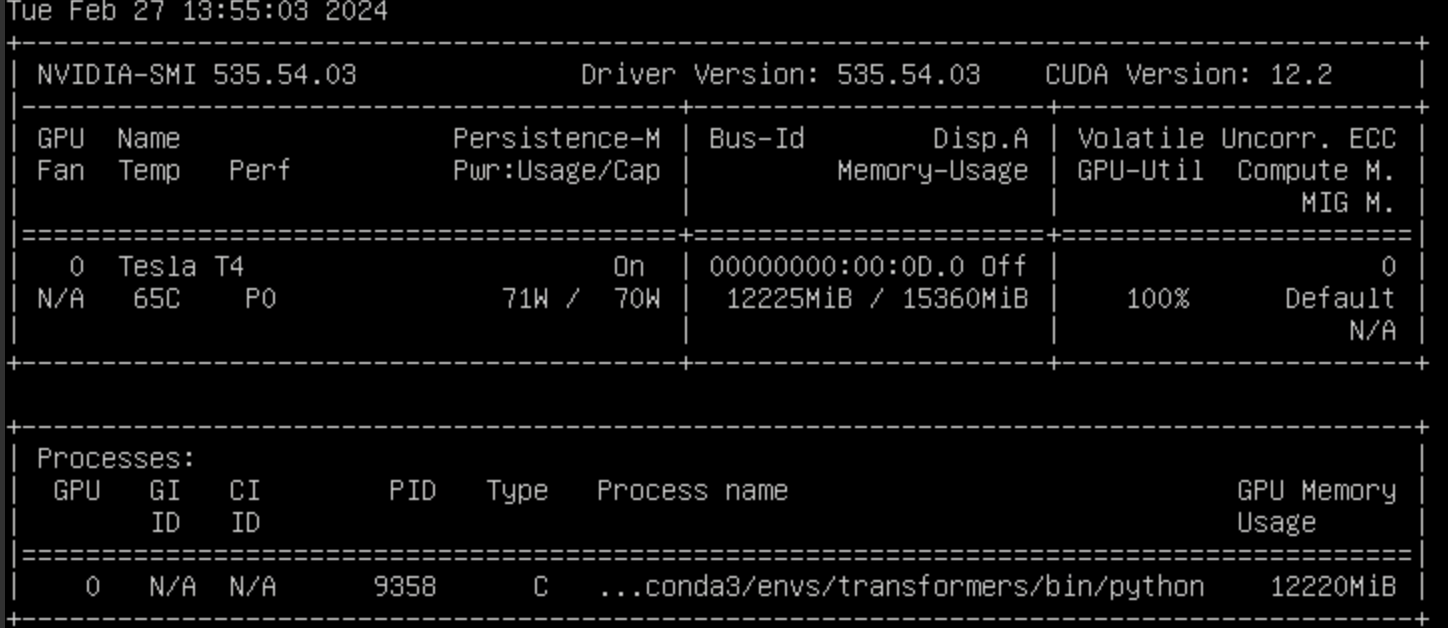

In [27]:
trainer.train()

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
/root/miniconda3/envs/transformers/lib/python3.11/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss
16,4.506600


NotADirectoryError: [Errno 20] Not a directory: '/root/miniconda3/envs/transformers/lib/python3.11/site-packages/huggingface_hub-0.20.3-py3.8.egg/huggingface_hub/templates/modelcard_template.md'